In [1]:
%matplotlib inline


In [2]:
import numpy as np

# Data Loading

In [3]:
# Useful Constants

# Output classes to learn how to classify
LABELS = [    
    "afrobeat",
    "classical",
    "hiphop"
] 
DATASET_PATH = "../dataset/finalData/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

n_steps = 100 # 100 timesteps per series
n_categories = len(LABELS)

In [4]:
# Load the networks inputs when we have n_steps

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs
def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1


X_train = load_X(X_train_path)
X_test = load_X(X_test_path)

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [5]:
# # Load the networks inputs 

# def load_X(X_path):
#     file = open(X_path, 'r')
#     X_ = np.array(
#         [elem for elem in [
#             row.split(',') for row in file
#         ]], 
#         dtype=np.float32
#     )
#     file.close()
    

#     return X_ 

# # Load the networks outputs
# def load_y(y_path):
#     file = open(y_path, 'r')
#     y_ = np.array(
#         [elem for elem in [
#             row.replace('  ', ' ').strip().split(' ') for row in file
#         ]], 
#         dtype=np.int32
#     )
#     file.close()
    
#     # for 0-based indexing 
#     return y_ - 1


# X_train = load_X(X_train_path)
# X_test = load_X(X_test_path)

# y_train = load_y(y_train_path)
# y_test = load_y(y_test_path)

In [6]:
print("X_train[0]", X_train[0])
print("Y_train[0]", y_train[0])

X_train[0] [[292.18155    379.94653      0.94605    ... 300.8205     630.476
    0.89430946]
 [164.67238    372.5236       0.91066056 ... 127.95229    632.90234
    0.86742735]
 [292.27213    380.3854       0.94750464 ... 300.88342    630.11273
    0.89574   ]
 ...
 [135.75566    351.15054      0.9302553  ...  53.104065   628.8599
    0.8303319 ]
 [256.38632    389.62808      0.9459007  ... 202.20776    632.0058
    0.8072443 ]
 [123.51268    348.48224      0.91950524 ...  36.507484   638.4996
    0.7896002 ]]
Y_train[0] [0]


# Preprocess

In [7]:
import torch

In [8]:
tensor_X_test = torch.from_numpy(X_test)
print('test_data_size:',tensor_X_test.size())
tensor_y_test = torch.from_numpy(y_test)
print('test_label_size:',tensor_y_test.size())
n_data_size_test = tensor_X_test.size()[0]
print('n_data_size_test:',n_data_size_test)

tensor_X_train = torch.from_numpy(X_train)
print('train_data_size:',tensor_X_train.size())
tensor_y_train = torch.from_numpy(y_train)
print('train_label_size:',tensor_y_train.size())
n_data_size_train = tensor_X_train.size()[0]
print('n_data_size_train:',n_data_size_train)

test_data_size: torch.Size([129, 100, 51])
test_label_size: torch.Size([129, 1])
n_data_size_test: 129
train_data_size: torch.Size([1050, 100, 51])
train_label_size: torch.Size([1050, 1])
n_data_size_train: 1050


In [9]:
import torch.nn as nn

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim,hidden_dim,layer_num,batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        self.bn = nn.BatchNorm1d(100)
        
    def forward(self,inputs):
        x = self.bn(inputs)
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [12]:
n_hidden = 128
n_joints = 51
n_categories = 3
n_layer = 3
rnn = LSTM(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM(
  (lstm): LSTM(51, 128, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

# Getting Random Data

In [14]:
import random
def randomTrainingExampleBatch(batch_size,flag,num=-1):
    if flag == 'train':
        X = tensor_X_train
        y = tensor_y_train
        data_size = n_data_size_train
    elif flag == 'test':
        X = tensor_X_test
        y = tensor_y_test
        data_size = n_data_size_test
    if num == -1:
        # ran_num = random.randint(0, batch_size)
        ran_num = 0
        # print("rand", ran_num)
        # print("data_size", data_size)
    else:
        ran_num = num
    pose_sequence_tensor = X[ran_num:(ran_num+batch_size)]
    pose_sequence_tensor = pose_sequence_tensor
    # print(y.shape)
    category_tensor = y[ran_num:ran_num+batch_size,:]
    # print("ccat", y[ran_num:ran_num+batch_size,:])
    return category_tensor.long(),pose_sequence_tensor

# Training

In [15]:
import torch.optim as optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)

n_iters = 10000
#n_iters = 60000
print_every = 500
plot_every = 10
batch_size = 50
# Keep track of losses for plotting
current_loss = 0
all_losses = []
right =  0
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category_tensor, input_sequence = randomTrainingExampleBatch(batch_size,'train')
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    
    optimizer.zero_grad()
    
    output = rnn(input_sequence)
    # print(input_sequence.shape)
    # print(category_tensor.shape)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step() 
    #scheduler.step()
    
    #如果tensor只有一个元素,那么可以用.item()的方法取出这个元素作为普通的python数字.
    current_loss += loss.item()
    
    category = LABELS[int(category_tensor[0])]
    guess, guess_i = categoryFromOutput(output)
    if guess == category:
            right += 1

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f  / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, guess, correct))
        print(right)

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
   

50 0% (0m 4s) 0.7401  / afrobeat ✓
50
100 1% (0m 8s) 0.4879  / afrobeat ✓
100
150 1% (0m 13s) 0.3216  / afrobeat ✓
150
200 2% (0m 17s) 0.2145  / afrobeat ✓
200
250 2% (0m 21s) 0.1469  / afrobeat ✓
250
300 3% (0m 25s) 0.1044  / afrobeat ✓
300
350 3% (0m 30s) 0.0772  / afrobeat ✓
350
400 4% (0m 34s) 0.0591  / afrobeat ✓
400
450 4% (0m 38s) 0.0467  / afrobeat ✓
450
500 5% (0m 42s) 0.0380  / afrobeat ✓
500
550 5% (0m 47s) 0.0315  / afrobeat ✓
550
600 6% (0m 51s) 0.0267  / afrobeat ✓
600
650 6% (0m 56s) 0.0230  / afrobeat ✓
650
700 7% (1m 0s) 0.0200  / afrobeat ✓
700
750 7% (1m 5s) 0.0176  / afrobeat ✓
750
800 8% (1m 9s) 0.0157  / afrobeat ✓
800
850 8% (1m 14s) 0.0141  / afrobeat ✓
850
900 9% (1m 18s) 0.0127  / afrobeat ✓
900
950 9% (1m 23s) 0.0116  / afrobeat ✓
950
1000 10% (1m 28s) 0.0106  / afrobeat ✓
1000
1050 10% (1m 32s) 0.0098  / afrobeat ✓
1050
1100 11% (1m 36s) 0.0091  / afrobeat ✓
1100
1150 11% (1m 41s) 0.0084  / afrobeat ✓
1150
1200 12% (1m 46s) 0.0078  / afrobeat ✓
1200
1250 12%

In [16]:
stop
torch.save(rnn.state_dict(),'danceClassification.pkl')

NameError: name 'stop' is not defined

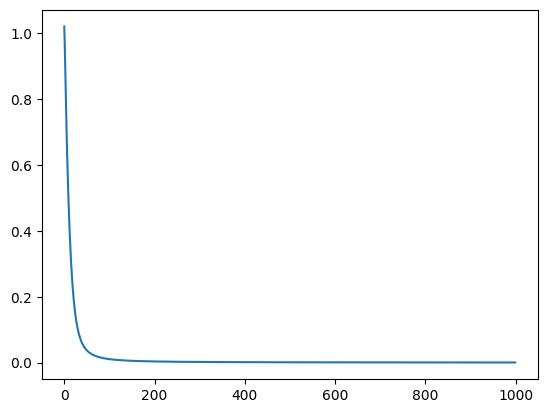

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
rnn.eval()

LSTM(
  (lstm): LSTM(51, 128, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [18]:
def test(flag):
    # rnn.eval()
    if flag == 'train':
        n = n_data_size_train
    elif flag == 'test':
        n = n_data_size_test   
        print(n)
    with torch.no_grad():
        right = 0
        for i in range(104):
            category_tensor, inputs = randomTrainingExampleBatch(1,flag,i)
            print(i)
            print(category_tensor.shape)
            category = LABELS[int(category_tensor[0])]
            
            print((category))
            inputs = inputs.to(device)
            # inputs = inputs.unsqueeze(1)
            output = rnn(inputs)
            guess, guess_i = categoryFromOutput(output)
            category_i = LABELS.index(category)
            if category_i == guess_i:
                right+=1
            print(right)
            print(n)
    print(flag,'accuracy',right/n)

In [19]:
test('test')

129
0
torch.Size([1, 1])
afrobeat
1
129
1
torch.Size([1, 1])
afrobeat
2
129
2
torch.Size([1, 1])
afrobeat
3
129
3
torch.Size([1, 1])
afrobeat
4
129
4
torch.Size([1, 1])
afrobeat
5
129
5
torch.Size([1, 1])
afrobeat
6
129
6
torch.Size([1, 1])
afrobeat
7
129
7
torch.Size([1, 1])
afrobeat
8
129
8
torch.Size([1, 1])
afrobeat
9
129
9
torch.Size([1, 1])
afrobeat
10
129
10
torch.Size([1, 1])
afrobeat
11
129
11
torch.Size([1, 1])
afrobeat
12
129
12
torch.Size([1, 1])
afrobeat
13
129
13
torch.Size([1, 1])
afrobeat
14
129
14
torch.Size([1, 1])
afrobeat
15
129
15
torch.Size([1, 1])
afrobeat
16
129
16
torch.Size([1, 1])
afrobeat
17
129
17
torch.Size([1, 1])
afrobeat
18
129
18
torch.Size([1, 1])
afrobeat
19
129
19
torch.Size([1, 1])
afrobeat
20
129
20
torch.Size([1, 1])
afrobeat
21
129
21
torch.Size([1, 1])
afrobeat
22
129
22
torch.Size([1, 1])
afrobeat
23
129
23
torch.Size([1, 1])
afrobeat
24
129
24
torch.Size([1, 1])
afrobeat
25
129
25
torch.Size([1, 1])
afrobeat
26
129
26
torch.Size([1, 1])
afrob

In [20]:
test('train')

0
torch.Size([1, 1])
afrobeat
1
1050
1
torch.Size([1, 1])
afrobeat
2
1050
2
torch.Size([1, 1])
afrobeat
3
1050
3
torch.Size([1, 1])
afrobeat
4
1050
4
torch.Size([1, 1])
afrobeat
5
1050
5
torch.Size([1, 1])
afrobeat
6
1050
6
torch.Size([1, 1])
afrobeat
7
1050
7
torch.Size([1, 1])
afrobeat
8
1050
8
torch.Size([1, 1])
afrobeat
9
1050
9
torch.Size([1, 1])
afrobeat
10
1050
10
torch.Size([1, 1])
afrobeat
11
1050
11
torch.Size([1, 1])
afrobeat
12
1050
12
torch.Size([1, 1])
afrobeat
13
1050
13
torch.Size([1, 1])
afrobeat
14
1050
14
torch.Size([1, 1])
afrobeat
15
1050
15
torch.Size([1, 1])
afrobeat
16
1050
16
torch.Size([1, 1])
afrobeat
17
1050
17
torch.Size([1, 1])
afrobeat
18
1050
18
torch.Size([1, 1])
afrobeat
19
1050
19
torch.Size([1, 1])
afrobeat
20
1050
20
torch.Size([1, 1])
afrobeat
21
1050
21
torch.Size([1, 1])
afrobeat
22
1050
22
torch.Size([1, 1])
afrobeat
23
1050
23
torch.Size([1, 1])
afrobeat
24
1050
24
torch.Size([1, 1])
afrobeat
25
1050
25
torch.Size([1, 1])
afrobeat
26
1050
26
to

C:\Users\audre\AppData\Local\Temp\ipykernel_22768\2499080590.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + LABELS, rotation=90)
C:\Users\audre\AppData\Local\Temp\ipykernel_22768\2499080590.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + LABELS)


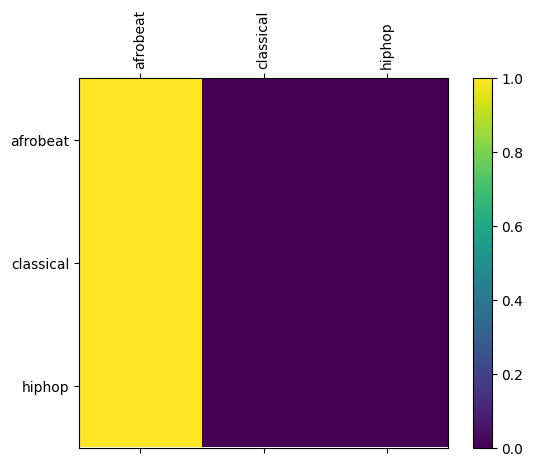

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = n_data_size_test

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category_tensor, inputs = randomTrainingExampleBatch(1,'test',i)
    category = LABELS[int(category_tensor[0])]
    inputs = inputs.to(device)
    output = rnn(inputs)
    guess, guess_i = categoryFromOutput(output)
    category_i = LABELS.index(category)
    confusion[category_i][guess_i] += 1
     
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + LABELS, rotation=90)
ax.set_yticklabels([''] + LABELS)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()